<a href="https://colab.research.google.com/github/Mr-Faizan-Asim/Alzheimer-Computer-Vision-Project/blob/main/Alzheimer_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

lukechugh_best_alzheimer_mri_dataset_99_accuracy_path = kagglehub.dataset_download('lukechugh/best-alzheimer-mri-dataset-99-accuracy')
muhammadfaizanasim_alzimer_path = kagglehub.dataset_download('muhammadfaizanasim/alzimer')
muhammadfaizanasim_abcd_other_default_1_path = kagglehub.model_download('muhammadfaizanasim/abcd/Other/default/1')

print('Data source import complete.')


100%|██████████| 71.5M/71.5M [00:00<00:00, 93.8MB/s]

Extracting files...



  0%|          | 0.00/49.5M [00:00<?, ?B/s]
  2%|▏         | 1.00M/49.5M [00:00<00:16, 3.03MB/s]
  8%|▊         | 4.00M/49.5M [00:00<00:04, 10.8MB/s]
 22%|██▏       | 11.0M/49.5M [00:00<00:01, 24.7MB/s]
 30%|███       | 15.0M/49.5M [00:00<00:01, 27.2MB/s]
 44%|████▍     | 22.0M/49.5M [00:00<00:00, 36.4MB/s]
 57%|█████▋    | 28.0M/49.5M [00:00<00:00, 42.9MB/s]
 69%|██████▊   | 34.0M/49.5M [00:01<00:00, 47.4MB/s]
 79%|███████▉  | 39.0M/49.5M [00:01<00:00, 46.9MB/s]
100%|██████████| 49.5M/49.5M [00:01<00:00, 38.1MB/s]

Data source import complete.


In [4]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [6]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [8]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)

Num GPUs Available:  1
TensorFlow version: 2.18.0


In [9]:
# Extract the ZIP file
def extract_dataset(zip_path, extract_path):
    """Extract the dataset from a ZIP file"""
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Dataset extracted to {extract_path}")

In [10]:
# Function to explore the dataset and check for issues
def explore_dataset(data_dir):
    """Explore the dataset structure and count samples"""
    try:
        class_names = sorted(os.listdir(data_dir))
        class_names = [c for c in class_names if os.path.isdir(os.path.join(data_dir, c))]

        if not class_names:
            print(f"ERROR: No class directories found in {data_dir}")
            print(f"Contents of {data_dir}: {os.listdir(data_dir)}")
            return None, None

        print(f"Classes: {class_names}")

        total_samples = 0
        class_counts = {}

        for class_name in class_names:
            class_dir = os.path.join(data_dir, class_name)
            if os.path.isdir(class_dir):
                files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp'))]
                count = len(files)
                class_counts[class_name] = count
                total_samples += count
                print(f"Class {class_name}: {count} images")

                # Check first few images to ensure they can be loaded
                for img_file in files[:3]:
                    try:
                        img_path = os.path.join(class_dir, img_file)
                        img = load_img(img_path)
                        arr = img_to_array(img)
                        print(f"  Sample image shape: {arr.shape}, min: {arr.min()}, max: {arr.max()}")
                    except Exception as e:
                        print(f"  ERROR loading {img_path}: {str(e)}")

        print(f"Total samples: {total_samples}")

        return class_names, class_counts
    except Exception as e:
        print(f"Error exploring dataset: {str(e)}")
        return None, None

In [11]:
# Function to visualize sample images with improved error handling
def visualize_samples(data_dir, class_names, samples_per_class=2):
    """Visualize sample images from each class"""
    plt.figure(figsize=(15, 10))

    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue

        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp'))][:samples_per_class]

        for j, img_file in enumerate(image_files):
            try:
                img_path = os.path.join(class_dir, img_file)
                img = plt.imread(img_path)

                plt.subplot(len(class_names), samples_per_class, i*samples_per_class + j + 1)
                plt.imshow(img, cmap='gray')
                plt.title(f"{class_name}\n{img.shape}" if j == 0 else f"{img.shape}")
                plt.axis('off')

            except Exception as e:
                print(f"Error visualizing {img_file}: {str(e)}")

    plt.tight_layout()
    plt.show()

In [12]:
# Function to create an improved model for distinguishing subtle differences in MRI scans
def create_improved_multiclass_model(input_shape=(256, 256, 3), num_classes=4, use_grayscale=False):
    """Create a model specifically designed to distinguish between similar MRI classes"""
    # Adjust input shape for grayscale
    if use_grayscale:
        input_shape = (input_shape[0], input_shape[1], 1)

    # Create input layer
    inputs = Input(shape=input_shape)

    # Convert grayscale to 3 channels if needed
    if use_grayscale:
        x = tf.keras.layers.Conv2D(3, (1, 1))(inputs)
    else:
        x = inputs

    # Use DenseNet169 which has more parameters than DenseNet121
    base_model = DenseNet169(
        weights='imagenet',
        include_top=False,
        input_shape=(input_shape[0], input_shape[1], 3)
    )

    # Freeze early layers
    for layer in base_model.layers[:400]:
        layer.trainable = False

    # Make later layers trainable from the start
    for layer in base_model.layers[400:]:
        layer.trainable = True

    x = base_model(x)

    # Global pooling
    x = GlobalAveragePooling2D()(x)

    # Add more capacity with deeper layers
    x = BatchNormalization()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Add another layer with more capacity
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    # Add a layer focused on learning subtle features
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Final classification layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    # Custom learning rate
    optimizer = Adam(learning_rate=0.0002)

    # Compile model
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(multi_label=True)]
    )

    return model

In [13]:
# Function to plot training history
def plot_training_history(history):
    """Plot the training and validation metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')
    ax1.grid(True)

    # Plot training & validation loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

In [14]:
# Function to evaluate the model
def evaluate_multiclass_model(model, test_generator, class_names):
    """Evaluate model performance and visualize results for multi-class classification"""
    # Reset the test generator
    test_generator.reset()

    # Get predictions
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)

    # Get true labels - need to convert from one-hot back to class indices
    y_true = np.argmax(test_generator.labels, axis=1) if len(test_generator.labels.shape) > 1 else test_generator.labels

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Per-class accuracy
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    for i, accuracy in enumerate(class_accuracy):
        print(f"Class {class_names[i]} accuracy: {accuracy:.4f}")

    # Create a bar chart of class accuracies
    plt.figure(figsize=(12, 6))
    plt.bar(class_names, class_accuracy, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Accuracy')
    plt.title('Per-Class Accuracy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Plot confusion examples for the worst performing class
    worst_class_idx = np.argmin(class_accuracy)
    worst_class_name = class_names[worst_class_idx]
    print(f"\nAnalyzing confusion for worst performing class: {worst_class_name}")

    # Find indices of misclassified samples for the worst class
    misclassified_indices = np.where((y_true == worst_class_idx) & (y_pred != worst_class_idx))[0]

    # Show confusion examples if any exist
    if len(misclassified_indices) > 0:
        print(f"Found {len(misclassified_indices)} misclassified samples for class {worst_class_name}")

        # Reset the generator to get images
        test_generator.reset()
        all_images = []
        all_true = []
        for _ in range(len(test_generator)):
            images, labels = next(test_generator)
            all_images.append(images)
            all_true.append(labels)
            if len(all_images) * images.shape[0] >= len(y_true):
                break

        all_images = np.vstack(all_images[:len(test_generator)])

        # Plot a few examples of confusion
        n_examples = min(8, len(misclassified_indices))
        plt.figure(figsize=(16, 8))
        for i in range(n_examples):
            idx = misclassified_indices[i]
            img = all_images[idx]
            true_class = class_names[y_true[idx]]
            pred_class = class_names[y_pred[idx]]

            plt.subplot(2, 4, i+1)
            if img.shape[-1] == 1:  # Grayscale
                plt.imshow(img[:,:,0], cmap='gray')
            else:
                plt.imshow(img)
            plt.title(f"True: {true_class}\nPred: {pred_class}", fontsize=10)
            plt.axis('off')

        plt.tight_layout()
        plt.show()

In [15]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def main():
    # Base path for your Kaggle input
    base_dir = '/kaggle/input/best-alzheimer-mri-dataset-99-accuracy/Combined Dataset'
    train_dir = os.path.join(base_dir, 'train')
    test_dir  = os.path.join(base_dir, 'test')

    # Verify dataset structure
    print("\nVerifying dataset structure:")
    print("Base contents:", os.listdir(base_dir))
    print("Train subfolders:", os.listdir(train_dir))
    print("Test  subfolders:", os.listdir(test_dir))

    # Explore dataset
    print("\nExploring dataset...")
    class_names, class_counts = explore_dataset(train_dir)
    if not class_names:
        print("ERROR: Could not properly identify classes. Please check dataset structure.")
        return

    # Visualize samples
    print("\nVisualizing sample images...")
    visualize_samples(train_dir, class_names)

    # Build class weights
    class_indices = {name: idx for idx, name in enumerate(class_names)}
    class_weights = {}
    for name, idx in class_indices.items():
        if "Very Mild Impairment" in name:
            class_weights[idx] = 7.0
        elif "No Impairment" in name:
            class_weights[idx] = 2.0
        else:
            class_weights[idx] = 1.0
    print(f"Using class weights: {class_weights}")

    # Data augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.15,
        brightness_range=[0.9, 1.1],
        horizontal_flip=True,
        fill_mode='constant',
        cval=0,
        validation_split=0.2
    )
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    img_height, img_width = 256, 256
    batch_size = 16
    color_mode = 'grayscale'

    print(f"\nCreating training generator with color_mode={color_mode}...")
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        color_mode=color_mode,
        shuffle=True
    )

    validation_generator = test_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        color_mode=color_mode,
        shuffle=False
    )

    print("\nClass indices:", train_generator.class_indices)

    # Build model
    print("\nCreating improved 4-class model...")
    input_shape = (img_height, img_width, 1)
    model = create_improved_multiclass_model(input_shape=input_shape, num_classes=len(class_names), use_grayscale=True)
    model.summary()

    # Callbacks
    checkpoint = ModelCheckpoint(
        'alzheimers_model_4class_improved.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1
    )

    # Train
    print("\nTraining the improved 4-class model with weighted classes...")
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=40,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=[checkpoint, early_stopping, reduce_lr],
        class_weight=class_weights,
        verbose=1
    )

    # Plot history
    plot_training_history(history)

    # Evaluate
    print("\nEvaluating the improved model...")
    model.load_weights('alzheimers_model_4class_improved.h5')
    evaluate_multiclass_model(model, validation_generator, list(train_generator.class_indices.keys()))

    # Save
    model.save('alzheimers_classification_model_4class_improved.h5')



Verifying dataset structure:
Base contents: ['test', 'train']
Train subfolders: ['No Impairment', 'Very Mild Impairment', 'Moderate Impairment', 'Mild Impairment']
Test  subfolders: ['No Impairment', 'Very Mild Impairment', 'Moderate Impairment', 'Mild Impairment']

Exploring dataset...
Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
Class Mild Impairment: 2560 images
  Sample image shape: (128, 128, 3), min: 0.0, max: 246.0
  Sample image shape: (128, 128, 3), min: 0.0, max: 250.0
  Sample image shape: (128, 128, 3), min: 0.0, max: 251.0
Class Moderate Impairment: 2560 images
  Sample image shape: (128, 128, 3), min: 0.0, max: 255.0
  Sample image shape: (128, 128, 3), min: 0.0, max: 250.0
  Sample image shape: (128, 128, 3), min: 0.0, max: 250.0
Class No Impairment: 2560 images
  Sample image shape: (128, 128, 3), min: 0.0, max: 243.0
  Sample image shape: (128, 128, 3), min: 0.0, max: 251.0
  Sample image shape: (128, 128, 3), min: 0.0, 

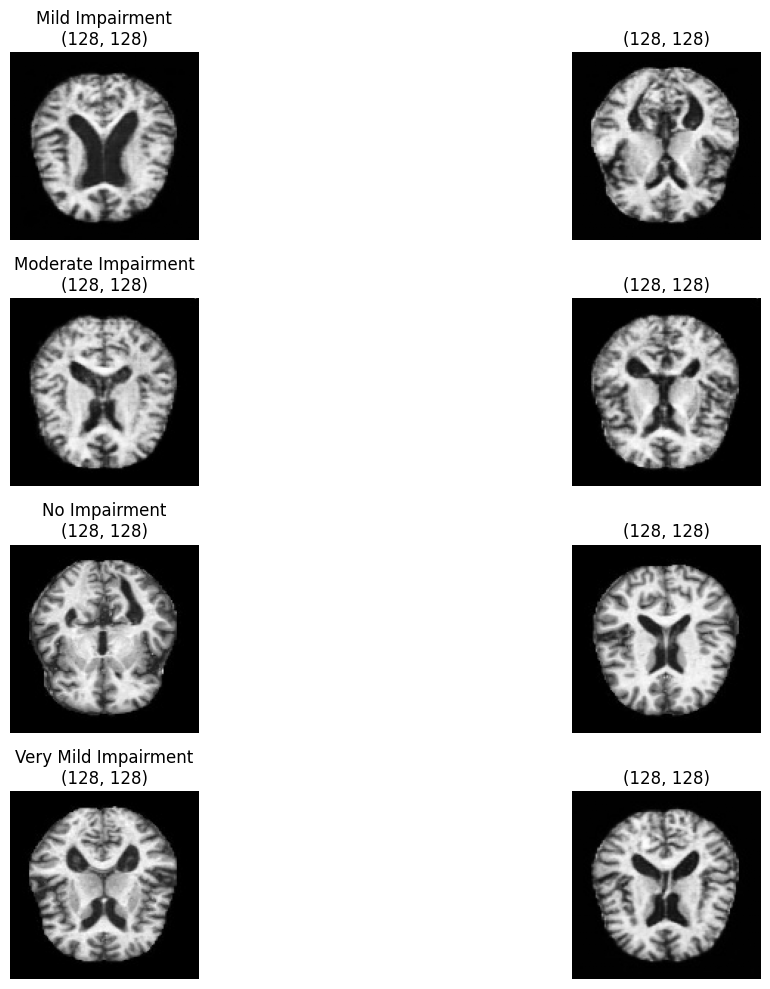

Using class weights: {0: 1.0, 1: 1.0, 2: 2.0, 3: 7.0}

Creating training generator with color_mode=grayscale...
Found 8192 images belonging to 4 classes.
Found 2048 images belonging to 4 classes.

Class indices: {'Mild Impairment': 0, 'Moderate Impairment': 1, 'No Impairment': 2, 'Very Mild Impairment': 3}

Creating improved 4-class model...
51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 3)    │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet169 (Functional)        │ (None, 8, 8, 1664)     │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1664)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1664)           │         6,656 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,704,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,018,826 (57.29 MB)

 Trainable params: 7,679,882 (29.30 MB)

 Non-trainable params: 7,338,944 (28.00 MB)


Training the improved 4-class model with weighted classes...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.4237 - auc: 0.6849 - loss: 4.1081
Epoch 1: val_accuracy improved from -inf to 0.61914, saving model to alzheimers_model_4class_improved.h5


512/512 ━━━━━━━━━━━━━━━━━━━━ 216s 210ms/step - accuracy: 0.4239 - auc: 0.6850 - loss: 4.1065 - val_accuracy: 0.6191 - val_auc: 0.8529 - val_loss: 0.9449 - learning_rate: 2.0000e-04
Epoch 2/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.6032 - auc: 0.8433 - loss: 2.1679
Epoch 2: val_accuracy improved from 0.61914 to 0.64990, saving model to alzheimers_model_4class_improved.h5


512/512 ━━━━━━━━━━━━━━━━━━━━ 83s 162ms/step - accuracy: 0.6032 - auc: 0.8434 - loss: 2.1677 - val_accuracy: 0.6499 - val_auc: 0.8629 - val_loss: 1.1398 - learning_rate: 2.0000e-04
Epoch 3/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.6528 - auc: 0.8860 - loss: 1.8264
Epoch 3: val_accuracy improved from 0.64990 to 0.69531, saving model to alzheimers_model_4class_improved.h5


512/512 ━━━━━━━━━━━━━━━━━━━━ 143s 163ms/step - accuracy: 0.6528 - auc: 0.8860 - loss: 1.8264 - val_accuracy: 0.6953 - val_auc: 0.8824 - val_loss: 0.7833 - learning_rate: 2.0000e-04
Epoch 4/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.6828 - auc: 0.9030 - loss: 1.6840
Epoch 4: val_accuracy did not improve from 0.69531
512/512 ━━━━━━━━━━━━━━━━━━━━ 82s 160ms/step - accuracy: 0.6828 - auc: 0.9030 - loss: 1.6839 - val_accuracy: 0.6606 - val_auc: 0.8604 - val_loss: 1.0110 - learning_rate: 2.0000e-04
Epoch 5/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7147 - auc: 0.9210 - loss: 1.4655
Epoch 5: val_accuracy improved from 0.69531 to 0.71143, saving model to alzheimers_model_4class_improved.h5


512/512 ━━━━━━━━━━━━━━━━━━━━ 83s 161ms/step - accuracy: 0.7147 - auc: 0.9210 - loss: 1.4655 - val_accuracy: 0.7114 - val_auc: 0.8972 - val_loss: 0.6799 - learning_rate: 2.0000e-04
Epoch 6/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7278 - auc: 0.9303 - loss: 1.3654
Epoch 6: val_accuracy did not improve from 0.71143
512/512 ━━━━━━━━━━━━━━━━━━━━ 81s 159ms/step - accuracy: 0.7279 - auc: 0.9303 - loss: 1.3653 - val_accuracy: 0.6885 - val_auc: 0.8873 - val_loss: 0.9779 - learning_rate: 2.0000e-04
Epoch 7/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7524 - auc: 0.9415 - loss: 1.2481
Epoch 7: val_accuracy did not improve from 0.71143
512/512 ━━━━━━━━━━━━━━━━━━━━ 81s 157ms/step - accuracy: 0.7525 - auc: 0.9415 - loss: 1.2481 - val_accuracy: 0.6685 - val_auc: 0.8658 - val_loss: 0.9456 - learning_rate: 2.0000e-04
Epoch 8/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7553 - auc: 0.9402 - loss: 1.2638
Epoch 8: val_accuracy did not improve from 0.71143
5

512/512 ━━━━━━━━━━━━━━━━━━━━ 82s 159ms/step - accuracy: 0.7844 - auc: 0.9542 - loss: 1.0673 - val_accuracy: 0.7144 - val_auc: 0.9027 - val_loss: 0.7423 - learning_rate: 2.0000e-04
Epoch 11/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7905 - auc: 0.9573 - loss: 1.0543
Epoch 11: val_accuracy did not improve from 0.71436
512/512 ━━━━━━━━━━━━━━━━━━━━ 80s 156ms/step - accuracy: 0.7905 - auc: 0.9573 - loss: 1.0543 - val_accuracy: 0.6855 - val_auc: 0.8968 - val_loss: 0.7035 - learning_rate: 2.0000e-04
Epoch 12/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8027 - auc: 0.9599 - loss: 1.0145
Epoch 12: val_accuracy did not improve from 0.71436

Epoch 12: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
512/512 ━━━━━━━━━━━━━━━━━━━━ 81s 158ms/step - accuracy: 0.8027 - auc: 0.9599 - loss: 1.0145 - val_accuracy: 0.7100 - val_auc: 0.8965 - val_loss: 0.7425 - learning_rate: 2.0000e-04
Epoch 13/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.819

512/512 ━━━━━━━━━━━━━━━━━━━━ 85s 165ms/step - accuracy: 0.8191 - auc: 0.9683 - loss: 0.8888 - val_accuracy: 0.7456 - val_auc: 0.9090 - val_loss: 0.8201 - learning_rate: 1.0000e-04
Epoch 14/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8314 - auc: 0.9704 - loss: 0.8532
Epoch 14: val_accuracy did not improve from 0.74561
512/512 ━━━━━━━━━━━━━━━━━━━━ 141s 163ms/step - accuracy: 0.8314 - auc: 0.9704 - loss: 0.8532 - val_accuracy: 0.7393 - val_auc: 0.9057 - val_loss: 0.8517 - learning_rate: 1.0000e-04
Epoch 15/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8514 - auc: 0.9759 - loss: 0.7590
Epoch 15: val_accuracy did not improve from 0.74561
512/512 ━━━━━━━━━━━━━━━━━━━━ 142s 163ms/step - accuracy: 0.8514 - auc: 0.9759 - loss: 0.7590 - val_accuracy: 0.7183 - val_auc: 0.8920 - val_loss: 1.0073 - learning_rate: 1.0000e-04
Epoch 16/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8562 - auc: 0.9793 - loss: 0.7050
Epoch 16: val_accuracy improved from 0.74561 

512/512 ━━━━━━━━━━━━━━━━━━━━ 81s 159ms/step - accuracy: 0.8562 - auc: 0.9793 - loss: 0.7051 - val_accuracy: 0.7637 - val_auc: 0.9183 - val_loss: 0.7046 - learning_rate: 1.0000e-04
Epoch 17/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8491 - auc: 0.9761 - loss: 0.7618
Epoch 17: val_accuracy did not improve from 0.76367
512/512 ━━━━━━━━━━━━━━━━━━━━ 82s 160ms/step - accuracy: 0.8491 - auc: 0.9761 - loss: 0.7617 - val_accuracy: 0.7090 - val_auc: 0.8948 - val_loss: 0.8849 - learning_rate: 1.0000e-04
Epoch 18/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8649 - auc: 0.9808 - loss: 0.6861
Epoch 18: val_accuracy did not improve from 0.76367
512/512 ━━━━━━━━━━━━━━━━━━━━ 83s 161ms/step - accuracy: 0.8649 - auc: 0.9808 - loss: 0.6861 - val_accuracy: 0.7471 - val_auc: 0.9120 - val_loss: 0.7452 - learning_rate: 1.0000e-04
Epoch 19/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8664 - auc: 0.9818 - loss: 0.6485
Epoch 19: val_accuracy improved from 0.76367 to


Epoch 19: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
512/512 ━━━━━━━━━━━━━━━━━━━━ 146s 170ms/step - accuracy: 0.8664 - auc: 0.9818 - loss: 0.6484 - val_accuracy: 0.7832 - val_auc: 0.9168 - val_loss: 0.9826 - learning_rate: 1.0000e-04
Epoch 20/40
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8788 - auc: 0.9840 - loss: 0.6164
Epoch 20: val_accuracy did not improve from 0.78320
512/512 ━━━━━━━━━━━━━━━━━━━━ 137s 161ms/step - accuracy: 0.8788 - auc: 0.9840 - loss: 0.6163 - val_accuracy: 0.7603 - val_auc: 0.9077 - val_loss: 1.0121 - learning_rate: 5.0000e-05
Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 5.


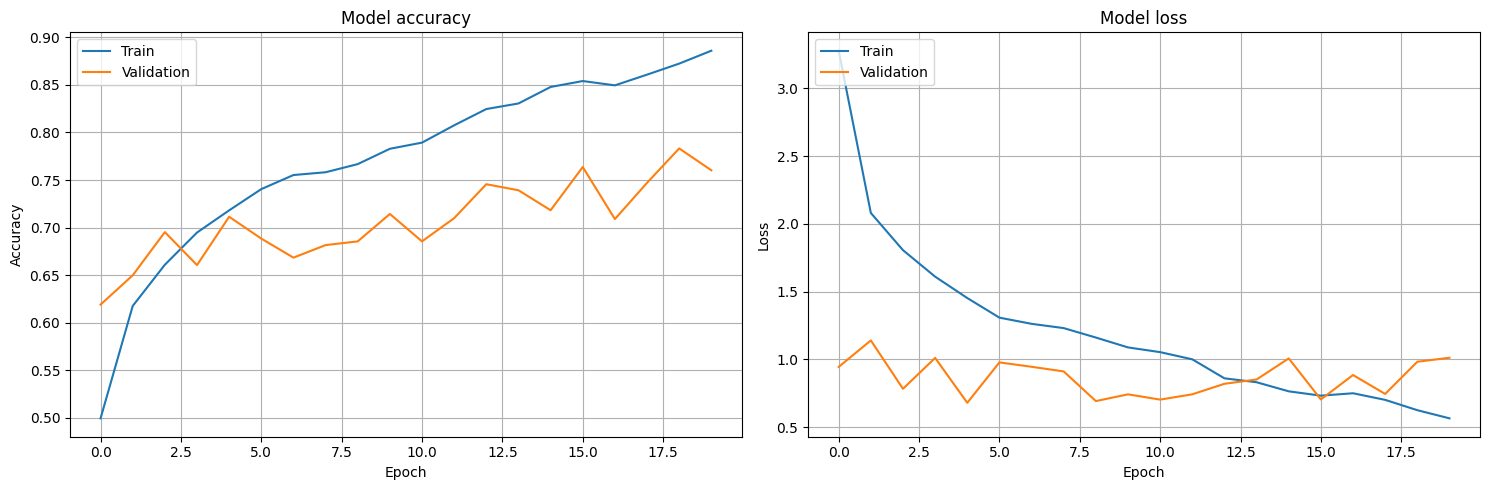


Evaluating the improved model...
128/128 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step


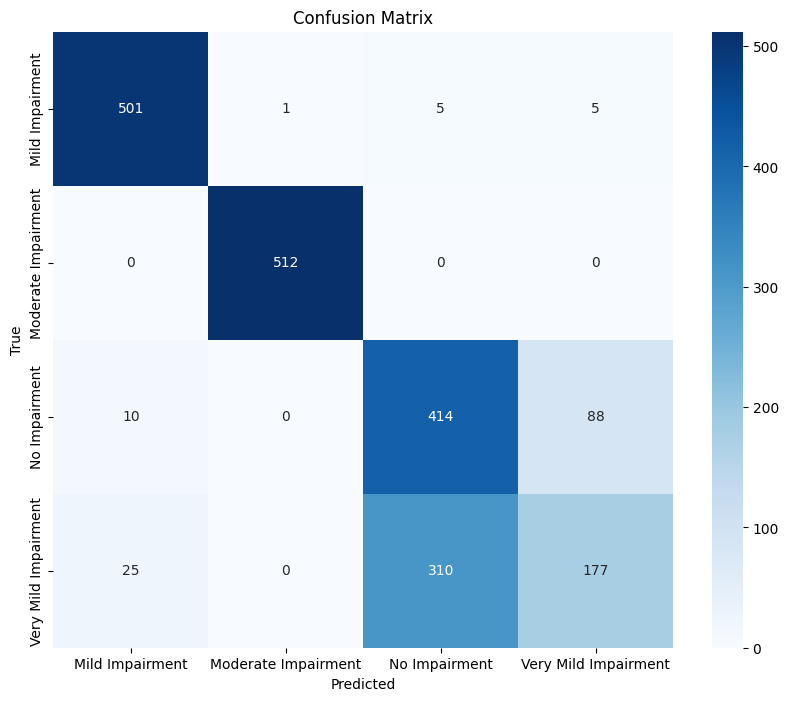


Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.93      0.98      0.96       512
 Moderate Impairment       1.00      1.00      1.00       512
       No Impairment       0.57      0.81      0.67       512
Very Mild Impairment       0.66      0.35      0.45       512

            accuracy                           0.78      2048
           macro avg       0.79      0.78      0.77      2048
        weighted avg       0.79      0.78      0.77      2048

Class Mild Impairment accuracy: 0.9785
Class Moderate Impairment accuracy: 1.0000
Class No Impairment accuracy: 0.8086
Class Very Mild Impairment accuracy: 0.3457


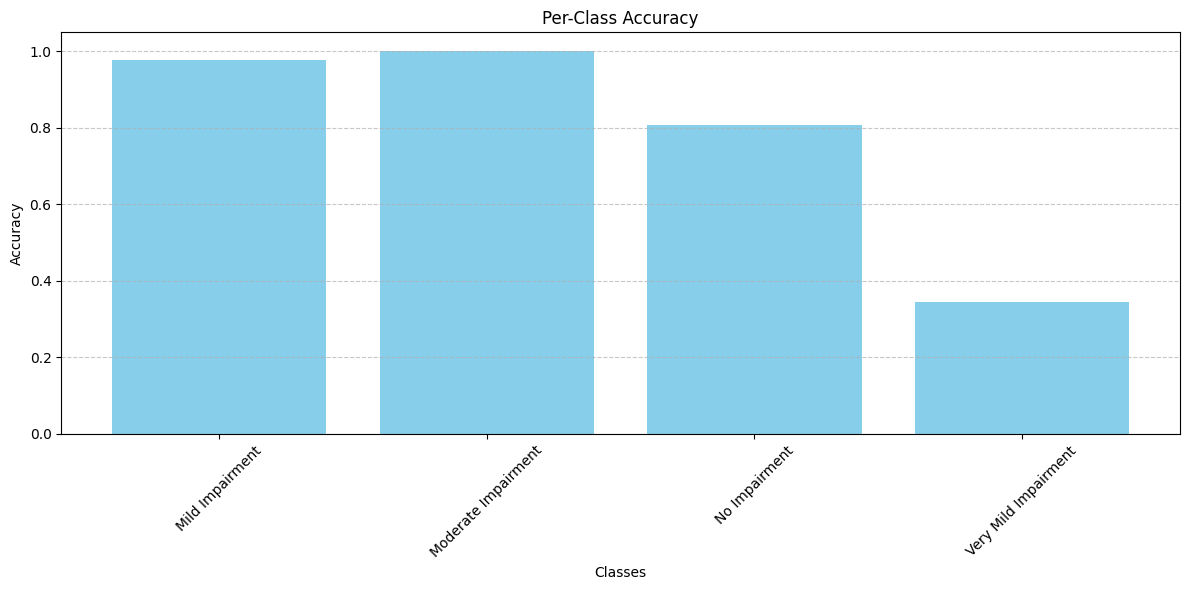


Analyzing confusion for worst performing class: Very Mild Impairment
Found 335 misclassified samples for class Very Mild Impairment


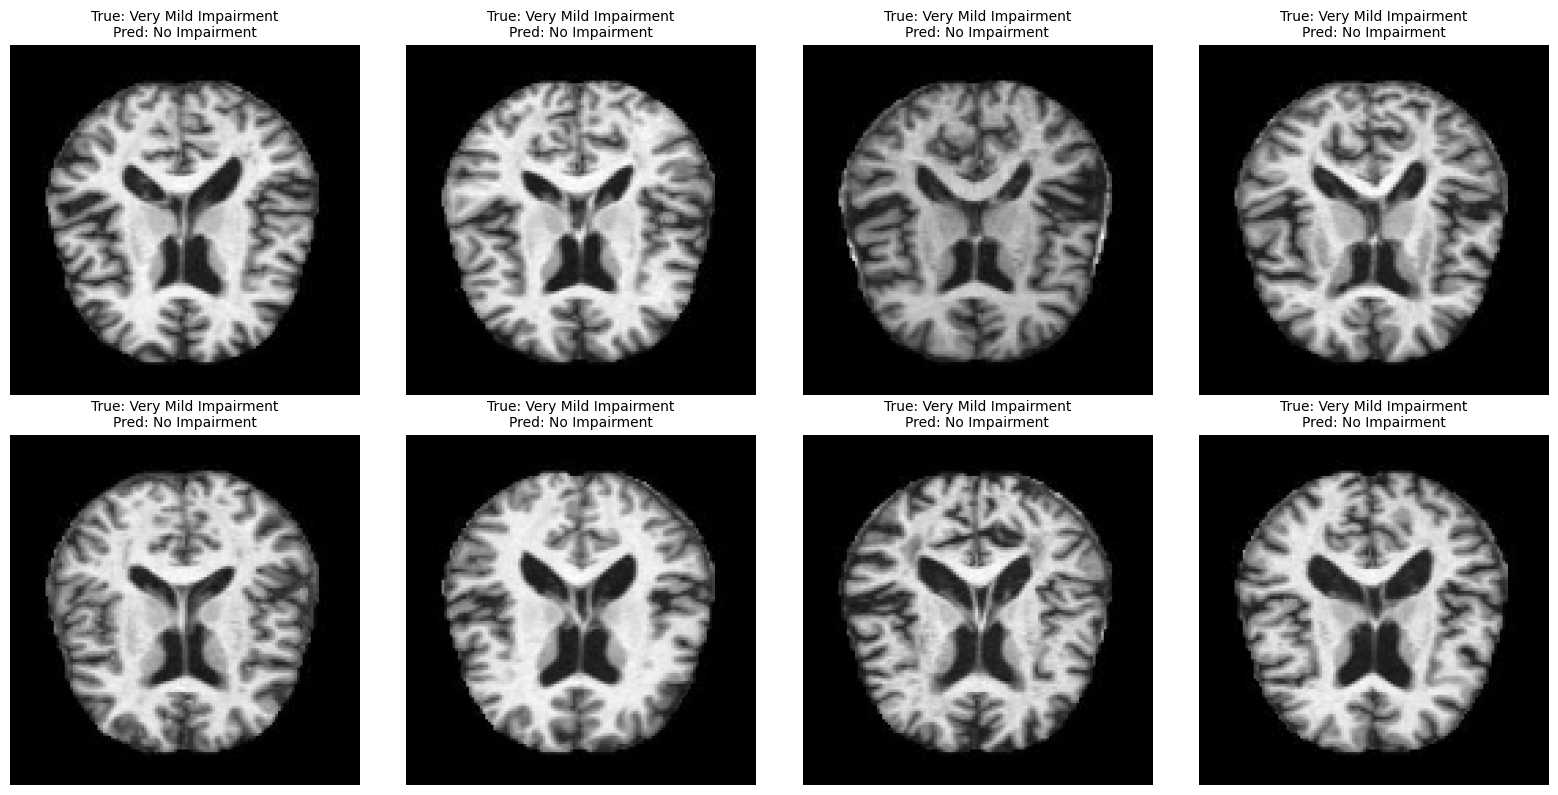

In [16]:
if __name__ == "__main__":
    main()